# Boundary Value Problems (BVPs) and Numerical Methods
This notebook demonstrates **numerical methods for solving BVPs** using **NumPy only**.

We will cover:
- Finite Difference Method
- Shooting Method

## 1. Finite Difference Method (FDM)

The **finite difference method** is a numerical technique used to approximate solutions to differential equations by replacing derivatives with difference equations. It is widely used in engineering and physics, especially for problems involving heat transfer, fluid flow, and structural analysis.

---

#### Example- FDM
We want to solve the ODE:

$$ y'' + y = 0, \quad y(0)=0, \; y(\pi/2)=1 $$

using the **finite difference method (FDM)**. We call these the Dirichlet Boundary Conditions. There are other types of boundary conditions. 

The exact solution is:

$$ y(x) = \sin(x) $$


#### Finite Difference Discretization
The ODE is:

$$ y'' + y = 0 $$

Discretize the interval [0, π/2] into N segments with step size h using central difference:

$$ y'' \approx \frac{y_{i-1} - 2y_i + y_{i+1}}{h^2} $$

So the general equation becomes:

$$ \frac{y_{i-1} - 2y_i + y_{i+1}}{h^2} + y_i = 0 $$

(**Note to self; you plug in  the y^n into our ODE eq. you find yi by collecting terms and solving for yi)

Rearrange:

$$ y_{i-1} + (-2 + h^2)y_i + y_{i+1} = 0 $$

This gives a tridiagonal system for unknowns y₁,...,yₙ₋₁.


#### Algorithm 
1. Discretize domain into n points- the continuous domain is divided into a grid of discrete points.

2. Apply central difference to approximate derivatives
3. Formulate linear system $Ax = b$
4. Incorporate boundary conditions
5. Solve using NumPy's linear solver



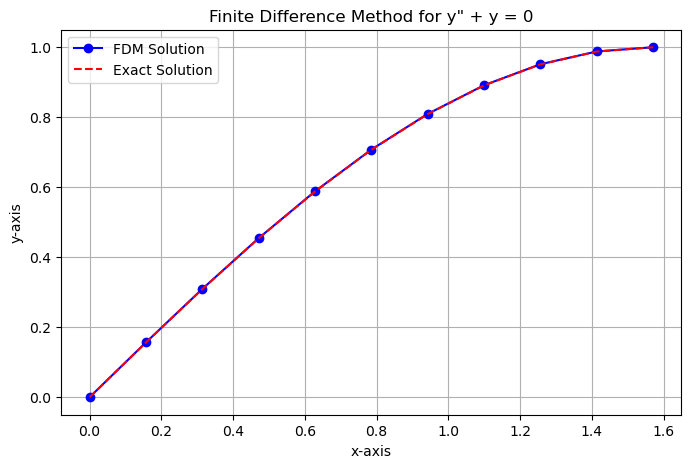

In [2]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 10  # number of intervals- N+1 points for N interval. In this case, 11 points.
a, b = 0, np.pi/2 # boundaries of the simulation domain
h = (b - a) / N # size of each grid

# Boundary conditions
y0, yN = 0, 1 # two known points, will be excluded from our solution set

# Build matrix A and vector b
# Could make a matrix A A = [[1, -2+h^2, 1, 0, 0, 0, 0, 0], ... ] by hand but we can actually do a for loop instead for more general use 
A = np.zeros((N-1, N-1))  # (N-1) x (N-1) array. For N = 10, the array A is 9 x 9; 9 unknown elements to solve for
b_vector = np.zeros(N-1)  # N-1 array

for i in range(N-1): # Indexing from 0 to N-2: this is how the system of eqns is built. once N = 10, the array A will be a square 9 x 9 matrix
    A[i, i] = -2 + h**2
    if i > 0:
        A[i, i-1] = 1
    if i < N-2:
        A[i, i+1] = 1

# Boundary conditions for vector
b_vector[0] -= y0   # Initial equation (index pos. 0)
b_vector[N-2] -= yN # Final equation (index pos. N-2)

# Solve linear system
Y_inner = np.linalg.solve(A, b_vector)    # Using linalg.solve with the parameters A, b_vec

# Incorporating boundaries into full solution now
Y = np.concatenate(([y0], Y_inner, [yN]))    # Concatenating the boundaries y0 and yN with the solved system Y_inner
x_vals = np.linspace(a, b, N+1)

# Producing exact solution by using defined x_vals
y_exact = np.sin(x_vals)

# Plotting!
plt.figure(figsize = (8,5))
plt.plot(x_vals, Y, 'bo-', label='FDM Solution')
plt.plot(x_vals, y_exact, 'r--', label='Exact Solution')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Finite Difference Method for y" + y = 0')
plt.legend()
plt.grid(True)
plt.show()

#### Exercise

Use Finite Difference Method (FDM) for a simply supported beam under uniform load to solves the bending Moment $ M(x)$ using $$ \frac{d^2 M}{dx^2} = -q $$

Boundary conditions: $M(0) = 0,  M(L) = 0 $

With the parameters in the code cell below, compare the bending moment with the exact solution:
$$ M(x)= 2q​x(L−x) $$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0       # Length of beam (m)
E = 200e9     # Young's modulus in Pascals
I = 1e-6      # Moment of inertia in m^4
q = 1         # Uniform load (N/m)
n = 101       # Number of grid points- Note the difference from the example above!!
dx = L / (n - 1)
x = np.linspace(0, L, n)

# Your code here
# Defining boundary conditions

## 2. Shooting Method
The shooting method converts a BVP into an IVP by guessing the initial slope and iteratively adjusting it until the boundary condition at the other end is satisfied.

**Algorithm Steps:**
1. Define the ODE as a system of first-order equations- Conver BVP to IVP
2. Guess an initial slope.
3. Integrate using a method (e.g., Runge-Kutta) until the end boundary.
4. Check boundary condition at endpoint.
5. Adjust the slope using a root-finding approach such as the Secant method. 


### Example- Shooting Method for Boundary Value Problem

We solve the ODE:

$$ y'' + y = 0, \quad y(0)=0, \; y(\pi/2)=1 $$

This is a well-posed problem. The exact solution is:

$$ y(x) = \sin(x) $$

We will use the **shooting method** with Runge-Kutta integration and secant method for slope adjustment.

Final slope found: 1.000001
Numerical solution @ x = pi/2: 1.000000 (target = 1)


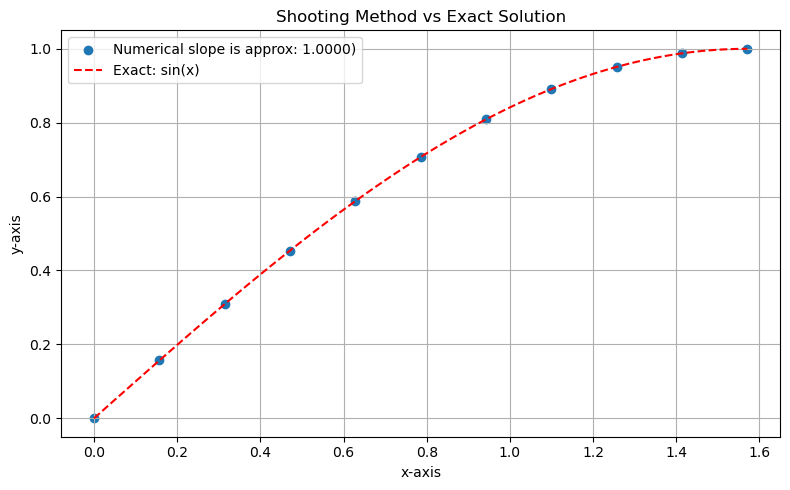

In [6]:
# Your code here- solution for y'= cos(x), y(0)=0
# Let's start with an IVP solver using RK4
# Plot your results

# Importing modules
import numpy as np
import matplotlib.pyplot as plt

# Defining the ODE system we were given: y'' + y = 0  --> y1' = y2
#                                      slope - first element of the ODE array
#                                      y2' = -y1 (relation from eqn; the second element of the ODE array)
def ode_system(x, y):
    return np.array([y[1], -y[0]])   # First element of the ODE system array (y1' - the slope)= second element of the solution y array (dy/dx = slope)
                                     # Second element of the ODE system array (y2')= -first element of the solution y array (y value)

# Runge-Kutta 4th order
def rk4_step(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h*k1/2)
    k3 = f(x + h/2, y + h*k2/2)
    k4 = f(x + h, y + h*k3)
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

# Integrating RK4
# Creating function 'integrate'; starts at x = 0; y(0) = 0 with an estimated slope
def integrate(slope, n=10):
    a, b = 0, np.pi/2       # Defining boundaries
    h = (b - a)/n           # Step size
    x_vals = np.linspace(a, b, n+1)     # Need n+1 points including the boundaries
    y = np.array([0.0, slope])
    sol = [y[0]]
    for i in range(n):       # Integrates to x = pi/2
        y = rk4_step(ode_system, x_vals[i], y, h)  # ODE function loops through the range of x_values
        sol.append(y[0])
        # print(sol)
    return x_vals, sol

# Shooting method function
def shooting_method(s1, s2, target, tol=1e-8, max_iter=100):
    x1, y1 = integrate(s1)
    x2, y2 = integrate(s2)
    for i in range(max_iter):
        f1, f2 = y1[-1] - target, y2[-1] - target
        if abs(f2 - f1) < 1e-14:
            break
        s_new = s2 - f2*(s2 - s1)/(f2 - f1)
        s1, s2 = s2, s_new
        x2, y2 = integrate(s2)
        if abs(y2[-1] - target) < tol:
            break
        i += 1
    return x2, y2, s2

# Utilizing shooting method and plugging x_num, y_num, slope into shooting_method function
x_num, y_num, slope = shooting_method(0.5, 5, 1.0)

# Exact solution: y(x) = sin(x)
x_exact = np.linspace(0, np.pi/2, 100)
y_exact = np.sin(x_exact)

print(f"Final slope found: {slope:.6f}")
print(f"Numerical solution @ x = pi/2: {y_num[-1]:.6f} (target = 1)")

# Plotting!
plt.figure(figsize = (8,5))
plt.scatter(x_num, y_num, label=f'Numerical slope is approx: {slope:.4f})')
plt.plot(x_exact, y_exact, 'r--', label='Exact: sin(x)')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Shooting Method vs Exact Solution')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
    

#### Exercise 

Use the shotting method for a simply supported beam under uniform load to solves the bending Moment $ M(x)$ using $$ \frac{d^2 M}{dx^2} = -q $$

Boundary conditions: $ M(0) = 0,  M(L) = 0 $

Compare the bending moment with the exact solution:
$$ M(x)= 2q​x(L−x) $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0       # Length of beam (m)
E = 200e9     # Young's modulus in Pascals
I = 1e-6      # Moment of inertia in m^4
w = 1      # Uniform load (N/m)
n = 101       # Number of grid points- Note the difference from the example above!!
dx = L / (n - 1)
x = np.linspace(0, L, n)

# Your code here